<a href="https://colab.research.google.com/github/AtogmatomaProgramming/OdonScanAI/blob/develop/manage_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *manage_model.ipynb*

Breve descripción: script para la creación del modelo que permita la identificación de la especie a través de imágenes.

## 1. Preparar librerías y características de trabajo

In [ ]:
# Importar librerías de trabajo

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [ ]:
# Establecer conexión directorio de trabajo
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/alpha_training/alt_frames/'

In [ ]:
# Configurar característica de las imágenes
img_height, img_width = 256, 256

In [ ]:
# Configurar tamaño mínimo para el lote de imágenes que se procesarán
batch_size = 32

## 2. Confirmación del número de imágenes de trabajo

In [ ]:
# Verificar distribución de imágenes por clase
def verificar_distribucion(data_dir):
    from collections import Counter
    class_counts = Counter()
    for image_class in os.listdir(data_dir):
        class_counts[image_class] += len(os.listdir(os.path.join(data_dir, image_class)))
    print("Distribución de imágenes por clase:")
    for clase, cantidad in class_counts.items():
        print(f"{clase}: {cantidad}")
    return class_counts

# Llamada para ver distribución
verificar_distribucion(data_dir)

Distribución de imágenes por clase:
elemento_desconocido: 680
lepidorhombus_whiffiagonis: 802
micromesistius_poutassou: 802


Counter({'elemento_desconocido': 680,
         'lepidorhombus_whiffiagonis': 802,
         'micromesistius_poutassou': 802})

## 3. Preparación de los datos para entrenamiento, validez y test

In [ ]:
# Empleo de la clase ImageDataGenerator
# para el tratamiento del conjunto de imágenes.
# En este caso se reescalan las mismas de valores de píxeles
# de 0-255 a 0-1 y se establece que el 40% del total de usen
# para validación
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.4
)

# Generación e las imágenes de entrenamiento, se establece
# el tamaño objetivo de las imágenes (definido anteriormente),
# el valor para la división de los lotes,
# que el valor de las clases es "categórico"
# y que emplee el 60 para entrenamiento

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Subdivisión de las imágenes de validación en
# 50% validación-50% test.
# Es decir, te queda un 20% del total de imágenes para
# validación y otro 20% para test

val_test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.5)

# Generación de las imágenes de validación

val_data = val_test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
    # Parámetro que mezcla (True) las imágenes para mejorar entrenamiento
)

# Generación de las imágenes de test

test_data = val_test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
    # En este caso no se mezclan para que las evaluaciones sean precisas
)

Found 1372 images belonging to 3 classes.
Found 1142 images belonging to 3 classes.
Found 1142 images belonging to 3 classes.


## 4. Definición de la red convolucional (CNN)

In [ ]:
# Definición del modelo de reconocimiento de imágenes
# a través de la API Sequential de TensorFlow

model = models.Sequential([
    # Primera capa convolucional, de 32 filtros
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    # Segunda capa convolucional, de 64 filtros
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Tercera capa convolucional, de 128 filtros
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Conversión de las capas de tensor multidimensional
    # a vector unidimensional
    layers.Flatten(),
    # Conexion total de las neuronas de las capas anteriores
    layers.Dense(128, activation='relu'),
    # Apagado de la mitad de neuronas en el entrenamiento
    # para favorecer la generalización
    layers.Dropout(0.5),
    # Capa final de salida del modelo. Se tienen tres neuronas
    # (una por etiqueta). A través de softmax, se asigna realiza la
    # predicción a través de la probabilidad más alta
    layers.Dense(len(train_data.class_indices), activation='softmax')
])

# Compilación del modelo, de cara a la optimización (adam) y mejora
# del mismo (categorical_crossentropy, accuracy)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 5. Entrenamiento del modelo

In [ ]:
# Entrenamiento del modelo, a través de los parámetros
# definidos en los pasos anteriores.

history = model.fit(
    train_data,
    validation_data=val_data,
    # Número total de "entrenamientos"
    # (procesado de imágenes y validación/test)
    epochs=20,
    steps_per_epoch=train_data.samples,
    validation_steps=val_data.samples
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 428s 9s/step - accuracy: 0.6517 - loss: 1.7745 - val_accuracy: 0.9768 - val_loss: 0.0762
Epoch 2/20
 1/42 ━━━━━━━━━━━━━━━━━━━━ 3:15 5s/step - accuracy: 0.9286 - loss: 0.2617

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 428ms/step - accuracy: 0.9286 - loss: 0.2617 - val_accuracy: 0.9545 - val_loss: 0.1007
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 295s 7s/step - accuracy: 0.9734 - loss: 0.1337 - val_accuracy: 0.9929 - val_loss: 0.0182
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 1.0000 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 286s 7s/step - accuracy: 0.9927 - loss: 0.0311 - val_accuracy: 0.9946 - val_loss: 0.0150
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 293s 7s/step - accuracy: 0.9906 - loss: 0.0226 - val_accuracy: 0.9982 - val_loss: 0.0056
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9545 - val_loss: 0.0874
Epoch 9/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 305s 7s/step - accuracy: 0.9868 - loss: 0.0474 - val_accuracy: 0.9732 - val_loss: 

## 6. Evaluación del modelo

In [ ]:
# Obtención de las clases evaluadas
test_labels = test_data.classes

# Predicciones en el conjunto de imágenes de prueba
test_preds = model.predict(test_data)

# Asignación de la clase más probable a las imágenes
test_preds_classes = np.argmax(test_preds, axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 213s 6s/step


In [ ]:
# Generación del informe de rendimiento de evaluación del modelo
print(classification_report(test_labels, test_preds_classes, target_names=class_names))

                            precision    recall  f1-score   support

      elemento_desconocido       0.58      0.99      0.73       340
lepidorhombus_whiffiagonis       0.99      0.70      0.82       401
  micromesistius_poutassou       1.00      0.69      0.82       401

                  accuracy                           0.78      1142
                 macro avg       0.86      0.79      0.79      1142
              weighted avg       0.87      0.78      0.79      1142



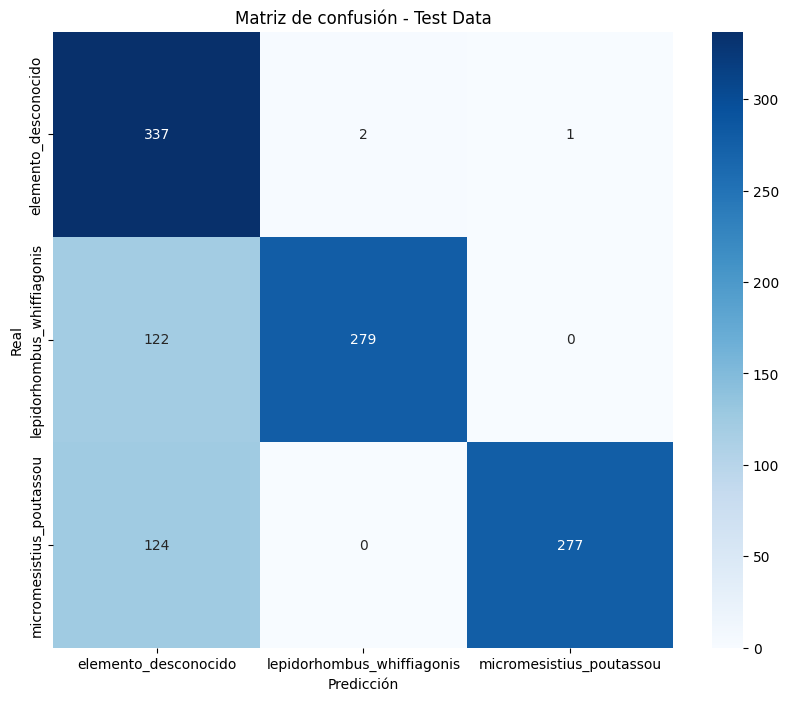

In [ ]:
# Gráfica de la matriz de confusión del modelo
cm = confusion_matrix(test_labels, test_preds_classes)
class_names = list(test_data.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión - Test Data')
plt.show()

In [ ]:
# Gráfica de la evolución del "Loss" y el "Accuracy" durante el entrenamiento

# Importar librería necesaria
import matplotlib.pyplot as plt

In [ ]:
# Funcion para dibujar dichas gráficas

def plot_training_history(history):

    # Obtener datos del historial
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    # Gráfica evolución "Loss"
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Loss de entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Loss de validación')
    plt.title('Evolución del Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfica evolución "Accuracy"
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Accuracy de entrenamiento')
    plt.plot(epochs, val_accuracy, 'r', label='Accuracy de validación')
    plt.title('Evolución del Accuracy')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()

    # Mostrar las gráficas
    plt.tight_layout()
    plt.show()

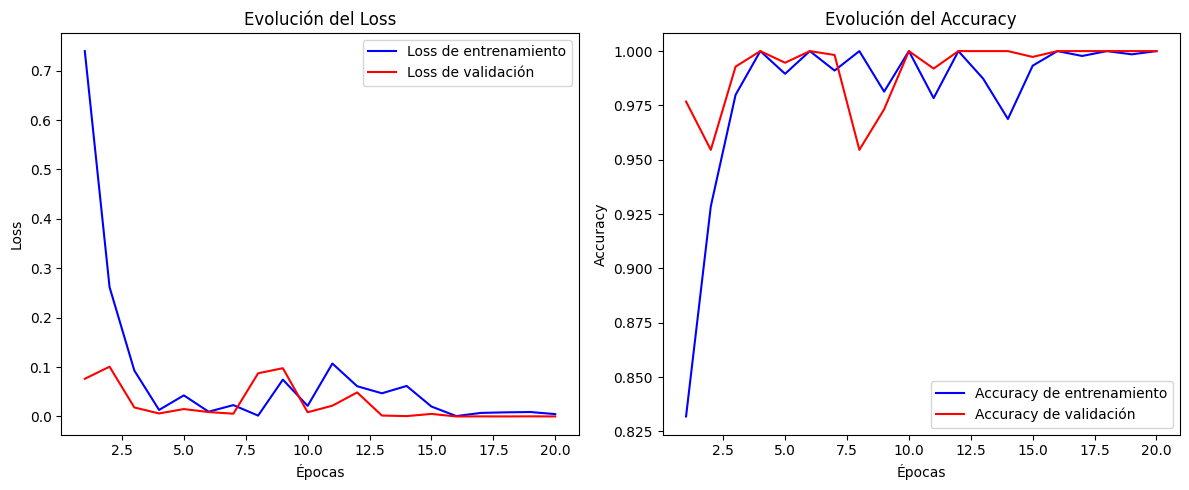

In [ ]:
# Empleo de la función

plot_training_history(history)

## 7. Guardado del modelo

In [ ]:
# Guardado del modelo en formato keras

model.save('/content/drive/My Drive/alpha_training/modelo_iota.keras')